### Import basic libraries

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
import itertools
%matplotlib inline

# **Part 1 - Preprocessing Transaction Rating Data**

# How do people rate each other on Bitcoin Marketplaces?

![TrustKeeperScore](img/TK_rating.png)

#### Load TRIMMED_NETWORK for extracting the node data that will be used to train models. Let's look at a portion of the table

In [12]:
sentiment = pd.read_csv("sentiment.csv")
sentiment

,rater,rating,notes,Score
0,sturles,1,great service,9
1,Keefe,7,timely response,7
2,BigBitz,1,nanooooo!,-5
3,Michail1,5,.,1
4,Blazed,4,several deals..Smooth™,8
5,ne0futur,8,NaN,0
6,Ssateneth,3,:),6


In [13]:
trim_network = pd.read_csv('2_TRIMMED_NETWORK.csv')
trim_network.head()

,SOURCE,TARGET,RATING,TIMESTAMP,EPISODE
0,35,3952,1,1.365623e+09,21958
1,2125,5379,-1,1.392045e+09,32086
2,5227,5854,1,1.417038e+09,35751
3,6013,13492,-1,1.393304e+09,32395
4,6013,13495,-1,1.392008e+09,32075


#### Define function to extract node features from the network dataframe

In [14]:
def GetNodeFeatures(GDF,n):
    if n==0:
        return ['in_degree','pos_in_edges','neg_in_edges','out_degree','pos_out_edges','neg_out_edges']
    # Get sub-dataframes
    outgoing = GDF[GDF['SOURCE']==n].copy().reset_index(drop=True)
    incoming = GDF[GDF['TARGET']==n].copy().reset_index(drop=True)
    
    # Compute node degree (incoming)
    in_degree = len(incoming)
    
    # Compute node degree (outgoing)
    out_degree = len(outgoing)
    
    # Compute number of incoming nodes with positive ratings
    pos_in_edges = len([i for i in incoming.RATING.values if i>0])
    
    # Computer number of incoming nodes with negative ratings
    neg_in_edges = len([i for i in incoming.RATING.values if i<0])
    
    # Repeat for outgoing edges
    pos_out_edges = len([i for i in outgoing.RATING.values if i>0])
    
    # Computer number of incoming nodes with negative ratings
    neg_out_edges = len([i for i in outgoing.RATING.values if i<0])
    
    return np.array([in_degree,pos_in_edges,neg_in_edges,out_degree,pos_out_edges,neg_out_edges])

#### Obtain node features for all nodes in trimmed network

In [15]:
# Define list of nodes and sort it in ascending order
nodes = list( set(trim_network['SOURCE']) | set(trim_network['TARGET']) )
nodes.sort()

# Create NF, the node feature matrix
NF = np.zeros([len(nodes),6])
for i,n in enumerate(nodes):
    NF[i,:] = np.array(GetNodeFeatures(trim_network,n))
    
# Create a dataframe containing all these node features
NF_df = pd.DataFrame(columns=GetNodeFeatures(trim_network,0),data=NF,index=nodes)
NF_df.to_csv('trimmed_node_features.csv')

In [16]:
NF_df = pd.read_csv('trimmed_node_features.csv',index_col=0)

#### Create an edgelist file for the trimmed network

In [17]:
f = open('trimmed_network.edgelist','w')
for i in range(len(trim_network)):
    s = str(trim_network['SOURCE'][i])
    t = str(trim_network['TARGET'][i])
    f.write(s+' '+t+'\n')
f.close()

#### Run [Node2Vec](https://snap.stanford.edu/node2vec/) to learn an embedding for each node in the trimmed_network

We will set the embedding dimension to 14, the number of walks to 25, and the number of iterations to 15.

Run this command in your terminal inside this directory (make sure your python environment is set to python=2.7). This step will take a while
```bash
python ./node2vec/src/main.py --input ./trimmed_network.edgelist --output ./trimmed_network.emb --dimensions 14 --num-walks 25 --iter 15
```

#### Create dictionary of nodes:embeddings fromthe trimmed_network.emb file created above

In [18]:
n = []
e = []
with open('./trimmed_network.emb') as fin:
    for line in fin:
        node_emb = line.strip().split()
        n.append(node_emb[0])
        e.append(node_emb[1:])
n = n[1:]
n = [int(i) for i in n]
embs = np.zeros([len(e)-1,14])
for i in range(1,len(e)):
    embs[i-1] = e[i]
embs.shape

(9664, 14)

#### Create a 2D projection of the embeddings using [t-SNE](https://lvdmaaten.github.io/tsne/)

In [19]:
#tsne = manifold.TSNE(n_components=2, init='pca', random_state=0)
#proj = tsne.fit_transform(embs)
#np.save('trimmed_network_tSNE_projection.npy',proj)
proj = np.load('trimmed_network_tSNE_projection.npy')

#### Plot node projections and color them according to the Bitcoin Marketplace they belong to (OTC or ALPHA)

In [20]:
alpha_nodes = []
otc_nodes = []
for i in range(len(n)):
    if n[i] > 6005: # The highest OTC node ID is 6005
        alpha_nodes.append(i)
    else:
        otc_nodes.append(i)

Text(0.5,1,'2-dimensional mapping with t-SNE of Bitcoin network nodes with Node2Vec')

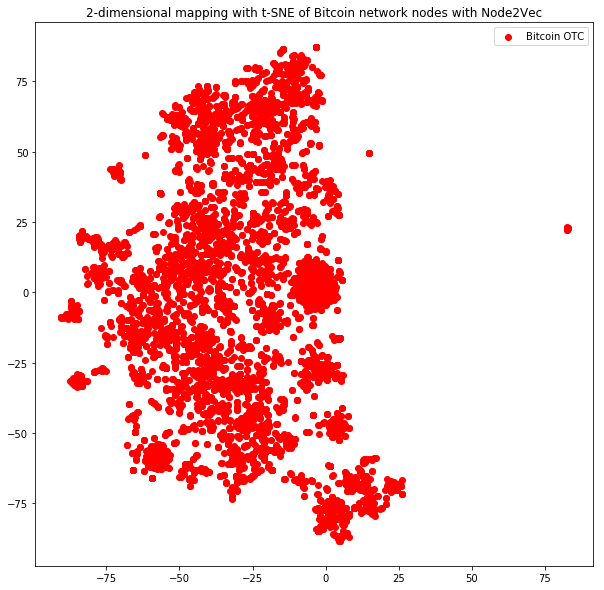

In [21]:
plt.figure(figsize=(10,10))
alpha = proj[alpha_nodes,:]
otc = proj[otc_nodes,:]
plt.scatter(otc[:,0],otc[:,1],c='r',label='Bitcoin OTC')
plt.legend()
plt.title('2-dimensional mapping with t-SNE of Bitcoin network nodes with Node2Vec')

#### Thus, Node2Vec is able to represent nodes in a 14-dimensional space that accounts for the network structure the nodes' neighborhoods. We will expand these node representations by concatenating the 6 node features we calculated earlier so that we get a final 20-dimensional representation for each node.

#### **Normalize node features and concatenate with Node2Vec embeddings**

In [22]:
NF_matrix = np.zeros([len(n),20]) # Recall that we have 14 Node2Vec features plus 6 features extracted from the rating network
for i in range(len(n)):
    NF_matrix[i] = np.concatenate([embs[i],np.log2(NF_df.loc[n[i]].values + 1)])
NF_matrix.shape

(9664, 20)

#### Because all 20 features have different scales, we will normalize the entire matrix using the following formula:

$$X_{normalized}=\frac{X - \mu_{X}}{\sigma_{X}}$$

Where $\mu_X$ and $\sigma_X$ are the columnwise mean/STD values of the matrix $X$. In this way, we ensure that all values in the matrix lie within the $[-3\sigma_X,3\sigma_X]$ range

In [23]:
NF_matrix_mean = np.mean(NF_matrix,axis=0)
NF_matrix_std = np.std(NF_matrix,axis=0)
NF_matrix_norm = ( NF_matrix - NF_matrix_mean ) / ( NF_matrix_std )

#### Capture node ID and embedding into a DataFrame

In [24]:
emb_df_norm = pd.DataFrame(columns=list(range(1,21)),index=n,data=NF_matrix_norm)
emb_df_norm.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
35,-1.774256,-0.448314,0.047397,0.612565,0.797896,-0.789905,-0.051981,-0.121641,-0.866701,0.772711,-0.960294,-0.634862,-0.391693,0.070921,5.995989,5.966601,-0.403738,5.764529,5.928494,5.244485
6006,-0.501574,-0.084692,0.723285,-1.407241,-0.649710,1.117009,0.567946,0.082475,-0.241229,-1.279825,0.483483,-0.937666,-1.084376,0.990163,5.628302,5.607510,-0.403738,5.253367,5.415542,2.245152
2642,-1.139167,-0.513084,1.118884,0.059454,-0.080315,-0.162173,0.315040,0.686051,0.649060,1.255844,-0.181627,0.228191,0.024559,-0.302619,5.577683,5.554465,1.132302,5.057479,5.198008,4.509349
2125,0.168152,0.876179,-0.513470,-0.215777,-0.248220,-0.916373,-0.365312,0.893897,0.826803,0.918575,-0.683717,1.040111,1.754360,-0.239251,4.613721,4.616648,-0.403738,5.057479,4.230008,12.063567
1810,0.072147,0.400560,0.326883,-0.186649,1.174607,-0.715021,-0.125926,1.679218,-0.296529,0.525661,-0.017292,0.255513,0.899269,0.118267,5.310770,5.124245,7.598189,5.026762,4.650978,11.015487


In [25]:
emb_df_norm.to_csv('./trimmed_node_embeddings_mean_normalized.csv')

#### Construct the input matrix $X$ and the output vector $y$. Each row of the $X$ matrix contains 40 values (20 values for the source node or buyer, 20 values for the target node or seller). The $y$ vector captures the rating of the transaction the seller received from the buyer. 

#### **NOTE:** Here we assign a score of 1 if transaction is rated badly (fraud), and 0 otherwise

In [26]:
#emb_df_norm = pd.read_csv('trimmed_node_embeddings_normalized.csv',index_col=0)
#emb_df_norm = pd.read_csv('trimmed_node_embeddings_normalized_with_log10.csv',index_col=0)
emb_df_norm = pd.read_csv('./trimmed_node_embeddings_mean_normalized.csv', index_col=0)

### Create X input matrix and y output vector

In [27]:
X = np.zeros([len(trim_network),40])
y = np.zeros(len(trim_network))
for i in range(len(trim_network)):
    s = trim_network['SOURCE'][i]
    t = trim_network['TARGET'][i]
    r = trim_network['RATING'][i]
    left = emb_df_norm.loc[s,:].values
    right = emb_df_norm.loc[t,:].values
    X[i,:] = np.concatenate([left,right])
    if r>0:
        y[i] = 0 # If not fraud
    else:
        y[i] = 1 # If fraud

#### Repeat procedure for calculating the $X_{val}$ and $y_{val}$ from the validation table

In [28]:
val_network = pd.read_csv('3_TEST_NETWORK.csv')
X_val = np.zeros([len(val_network),40])
y_val = np.zeros(len(val_network))
for i in range(len(val_network)):
    s = val_network['SOURCE'][i]
    t = val_network['TARGET'][i]
    r = val_network['RATING'][i]
    left = emb_df_norm.loc[s,:].values
    right = emb_df_norm.loc[t,:].values
    X_val[i,:] = np.concatenate([left,right])
    if r>0:
        y_val[i] = 0 # If not fraud
    else:
        y_val[i] = 1 # If fraud (class imbalance)

# **Part 2 - Model Construction, training, and evaluation**

#### Models evaluated:

* **TrusKeeper** (Deep Neural Network trained with both Node2Vec features and perception scores)
* Deep Neural Network trained with perception scores only
* Logistic Regression trained with both Node2Vec features and perception scores
* Logistic Regression trained with perception scores only

#### Load Machine/Deep Learning libraries

In [29]:
# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

# Deep Learning
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Input, Convolution2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.utils import np_utils
from keras.layers.merge import Concatenate

Using TensorFlow backend.


#### Define function for generating small samples from training data to train Neural Networks without biasing it towards the most abundant category (0)

In [30]:
# Create train and test sets
x_train, x_test, y_train, y_test = train_test_split(X,y,test_size= 0.2,random_state=0)
def CreateSample(frac=0.8):
    fraud_indices = np.array([i for i in range(len(y_train)) if y_train[i]==1])
    not_fraud_indices = np.array([i for i in range(len(y_train)) if y_train[i]==0])
    sample_size = int(np.round( len(fraud_indices) * frac ))
    fraud_sample = np.random.randint(0,len(fraud_indices),sample_size) 
    not_fraud_sample = np.random.randint(0,len(not_fraud_indices),sample_size)
    y_sample = np.concatenate([y_train[fraud_indices][fraud_sample],y_train[not_fraud_indices[not_fraud_sample]]])
    x_sample = np.concatenate([x_train[fraud_indices][fraud_sample],x_train[not_fraud_indices[not_fraud_sample]]])
    return x_sample,y_sample

### Define a function to plot Confusion Matrices

In [31]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### Construct TrustKeeper model

In [32]:
# Initialize model

input_size = 40 # Features from X matrix

M1 = Sequential()

# Add an input layer
M1.add(Dense(128, activation='relu', input_shape=(input_size,)))

# Add first hidden layer
M1.add(Dense(128, activation='relu'))

# Add second hidden layer
M1.add(Dense(64, activation='relu'))

#Add third hidden layer
M1.add(Dense(32, activation='relu'))

#Add fourth hidden layer
M1.add(Dense(16, activation='relu'))

# Add output layer
M1.add(Dense(1,activation='sigmoid'))

# Define optimizers
nadam = keras.optimizers.Nadam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

M1.compile(loss='binary_crossentropy',
              optimizer=nadam,
              metrics=['accuracy'])

# Define parameters
Nepochs = 10

Instructions for updating:
Colocations handled automatically by placer.


### Train Model using Bootstrapping

In [33]:
for i in range(15):
    sample_x,sample_y = CreateSample()
    M1.fit(sample_x, sample_y, epochs=Nepochs, batch_size=5, verbose=0)

Instructions for updating:
Use tf.cast instead.


### Evaluate Model 1 with test set

In [34]:
y_pred = M1.predict(x_test)

# Print classfication report
target_names = ['Honest','Fraudulent']
confusion_matrix = cm(y_test, np.round(y_pred))
print("Classification Report for TrustKeeper")
print(classification_report(y_test, np.round(y_pred)))

Classification Report for TrustKeeper
              precision    recall  f1-score   support

         0.0       0.99      0.93      0.96      9119
         1.0       0.57      0.93      0.70       846

   micro avg       0.93      0.93      0.93      9965
   macro avg       0.78      0.93      0.83      9965
weighted avg       0.96      0.93      0.94      9965



Normalized confusion matrix
[[0.93354534 0.06645466]
 [0.06737589 0.93262411]]


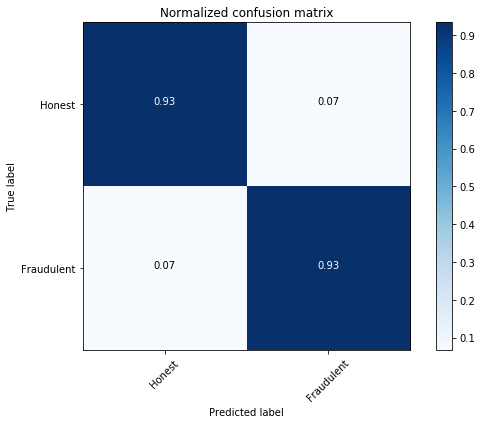

In [35]:
# Plot normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(confusion_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

### Existing model with validation set

In [36]:
y_pred = M1.predict(X_val)
# Print confusion matrix
confusion_matrix = cm(y_val, np.round(y_pred))
print("Classification Report for TrustKeeper (Validation set)")
print(classification_report(y_val, np.round(y_pred)))

Classification Report for TrustKeeper (Validation set)
              precision    recall  f1-score   support

         0.0       0.98      0.92      0.95      9075
         1.0       0.48      0.77      0.59       881

   micro avg       0.91      0.91      0.91      9956
   macro avg       0.73      0.84      0.77      9956
weighted avg       0.93      0.91      0.92      9956



Normalized confusion matrix
[[0.91922865 0.08077135]
 [0.2338252  0.7661748 ]]


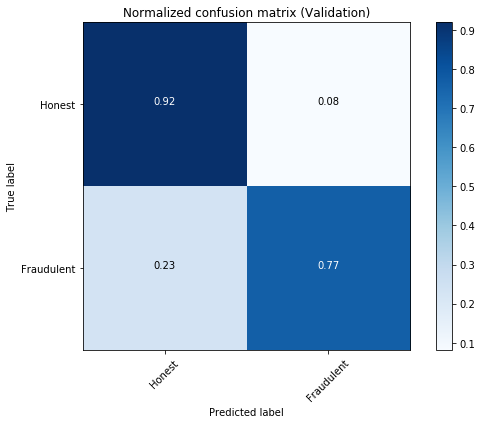

In [37]:
# Plot normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(confusion_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix (Validation)')

### Construct Neural Net model (without Node2Vec features)

In [38]:
# Initialize model

input_size = 12 # Features from X matrix (only the perception scores)

M2 = Sequential()

# Add an input layer
M2.add(Dense(128, activation='relu', input_shape=(input_size,)))

# Add first hidden layer
M2.add(Dense(128, activation='relu'))

# Add second hidden layer
M2.add(Dense(64, activation='relu'))

#Add third hidden layer
M2.add(Dense(32, activation='relu'))

#Add fourth hidden layer
M2.add(Dense(16, activation='relu'))

# Add output layer
M2.add(Dense(1,activation='sigmoid'))

# Define optimizers
nadam = keras.optimizers.Nadam(lr=1e-6, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004)
sgd = keras.optimizers.SGD(lr=1e-3, decay=1e-6, momentum=0.9, nesterov=True)

M2.compile(loss='binary_crossentropy',
              optimizer=nadam,
              metrics=['accuracy'])

# Define parameters
Nepochs = 10

### Train Model using Bootstrapping

In [39]:
cols_to_keep = list(range(14,20)) + list(range(34,40))
for i in range(15):
    sample_x,sample_y = CreateSample()
    M2.fit(sample_x[:,cols_to_keep], sample_y, epochs=Nepochs, batch_size=5, verbose=0)

### Evaluate Model 1 with test set

In [40]:
y_pred = M2.predict(x_test[:,cols_to_keep])

# Print classfication report
target_names = ['Honest','Fraudulent']
confusion_matrix = cm(y_test, np.round(y_pred))
print("Classification Report for Model 2 (NN w/o Node2Vec)")
print(classification_report(y_test, np.round(y_pred)))

Classification Report for Model 2 (NN w/o Node2Vec)
              precision    recall  f1-score   support

         0.0       0.99      0.94      0.97      9119
         1.0       0.59      0.95      0.73       846

   micro avg       0.94      0.94      0.94      9965
   macro avg       0.79      0.94      0.85      9965
weighted avg       0.96      0.94      0.95      9965



Model 2
Normalized confusion matrix
[[0.93946705 0.06053295]
 [0.05200946 0.94799054]]


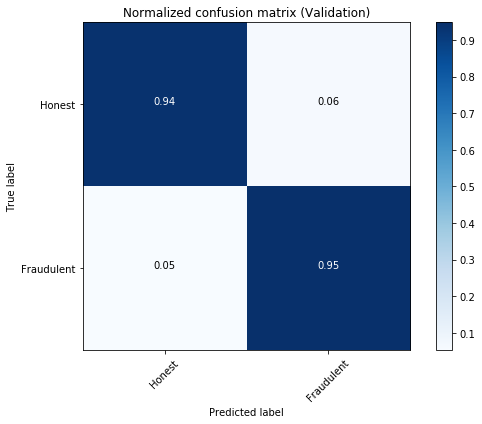

In [41]:
# Plot normalized confusion matrix
print('Model 2')
plt.figure(figsize=(8,6))
plot_confusion_matrix(confusion_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix (Validation)')

### Evaluate Model 2 with validation set

In [42]:
y_pred = M2.predict(X_val[:,cols_to_keep])
# Print confusion matrix
confusion_matrix = cm(y_val, np.round(y_pred))
print("Classification Report for TrustKeeper (Validation set)")
print(classification_report(y_val, np.round(y_pred)))

Classification Report for TrustKeeper (Validation set)
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.95      9075
         1.0       0.48      0.73      0.58       881

   micro avg       0.91      0.91      0.91      9956
   macro avg       0.73      0.83      0.76      9956
weighted avg       0.93      0.91      0.91      9956



Normalized confusion matrix
[[0.92264463 0.07735537]
 [0.26901249 0.73098751]]


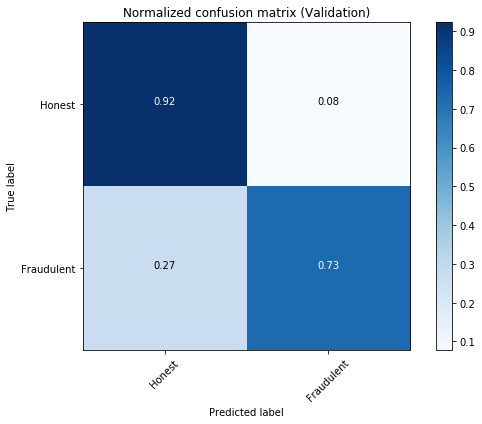

In [43]:
# Plot normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(confusion_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix (Validation)')

 ### Construct Model 3 (Logistic Regression with network features and perception scores)

In [44]:
M3 = LogisticRegression()

### Train Model 3

In [45]:
M3.fit(x_train, y_train)

/Users/Deepesh.Chaudhari/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Evaluate Model 3 with test data

In [46]:
y_pred = M3.predict(x_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(M3.score(x_test, y_test)))

confusion_matrix = cm(y_test, y_pred)
print("Classification Report for Logistic Regression")
print(classification_report(y_test, y_pred))

Accuracy of logistic regression classifier on test set: 0.96
Classification Report for Logistic Regression
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      9119
         1.0       0.84      0.66      0.74       846

   micro avg       0.96      0.96      0.96      9965
   macro avg       0.90      0.82      0.86      9965
weighted avg       0.96      0.96      0.96      9965



Normalized confusion matrix
[[0.98804693 0.01195307]
 [0.3392435  0.6607565 ]]


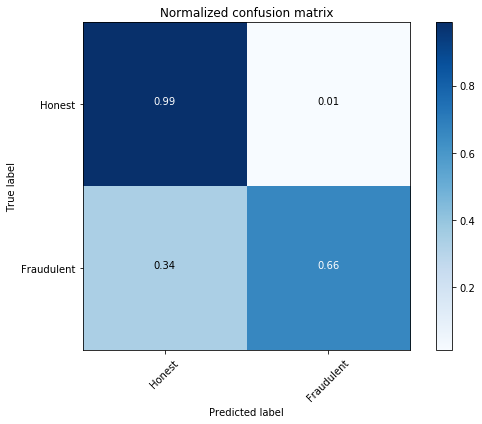

In [47]:
# Plot normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(confusion_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

### Evaluate Model 3 with validation data

In [48]:
y_pred = M3.predict(X_val)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(M3.score(X_val, y_val)))

confusion_matrix = cm(y_val, y_pred)
print("Classification Report for Logistic Regression (Validation)")
print(classification_report(y_val, y_pred))

Accuracy of logistic regression classifier on test set: 0.94
Classification Report for Logistic Regression (Validation)
              precision    recall  f1-score   support

         0.0       0.96      0.98      0.97      9075
         1.0       0.75      0.54      0.63       881

   micro avg       0.94      0.94      0.94      9956
   macro avg       0.85      0.76      0.80      9956
weighted avg       0.94      0.94      0.94      9956



Normalized confusion matrix
[[0.98236915 0.01763085]
 [0.45970488 0.54029512]]


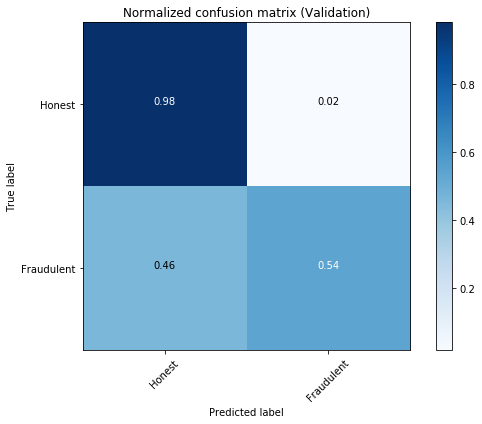

In [49]:
# Plot normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(confusion_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix (Validation)')

 ### Construct Model 4 (Logistic Regression without network features)

In [50]:
M4 = LogisticRegression()

### Train Model 4 with Bootstrapping

In [51]:
M4.fit(x_train[:,cols_to_keep], y_train)

/Users/Deepesh.Chaudhari/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

### Evaluate Model 4 with test data

In [52]:
y_pred = M3.predict(x_test[:,cols_to_keep])
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(M4.score(x_test[:,cols_to_keep], y_test)))

confusion_matrix = cm(y_test, y_pred)
print("Classification Report for Logistic Regression")
print(classification_report(y_test, y_pred))

ValueError: X has 12 features per sample; expecting 40

In [ ]:
# Plot normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(confusion_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix')

### Evaluate Model 4 with validation data

In [ ]:
y_pred = M4.predict(X_val[:,cols_to_keep])
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(M4.score(X_val[:,cols_to_keep], y_val)))

confusion_matrix = cm(y_val, y_pred)
print("Classification Report for Logistic Regression (Validation)")
print(classification_report(y_val, y_pred))

In [ ]:
# Plot normalized confusion matrix
plt.figure(figsize=(8,6))
plot_confusion_matrix(confusion_matrix, classes=target_names, normalize=True,
                      title='Normalized confusion matrix (Validation)')

### Save models

In [ ]:
import pickle
M1.save('Models/TrustKeeper.h5')
M2.save('Models/Model_2_NN.h5')
filename = 'Models/Model_3_LR.pickle'
pickle.dump(M3, open(filename, 'wb'))
filename = 'Models/Model_4_LR_no_Node2Vec.pickle'
pickle.dump(M4, open(filename, 'wb'))

# Plot ROC/AUC on validation data

In [ ]:
plt.figure(figsize=(8,8))

logit_roc_auc = roc_auc_score(y_val, M1.predict(X_val))
fpr, tpr, thresholds = roc_curve(y_val, M1.predict_proba(X_val))
plt.plot(fpr, tpr, alpha=0.8, linewidth=2.0,label='TrustKeeper (area = %0.2f)' % (logit_roc_auc))

logit_roc_auc = roc_auc_score(y_val, M2.predict(X_val[:,cols_to_keep]))
fpr, tpr, thresholds = roc_curve(y_val, M2.predict_proba(X_val[:,cols_to_keep]))
plt.plot(fpr, tpr, alpha=0.8, linewidth=2.0,label='NN w/o Node2Vec (area = %0.2f)' % (logit_roc_auc))

logit_roc_auc = roc_auc_score(y_val, M3.predict(X_val))
fpr, tpr, thresholds = roc_curve(y_val, M3.predict_proba(X_val)[:,1])
plt.plot(fpr, tpr, alpha=0.8, linewidth=2.0,label='LR (area = %0.2f)' % (logit_roc_auc))

logit_roc_auc = roc_auc_score(y_val, M4.predict(X_val[:,cols_to_keep]))
fpr, tpr, thresholds = roc_curve(y_val, M4.predict_proba(X_val[:,cols_to_keep])[:,1])
plt.plot(fpr, tpr, alpha=0.8, linewidth=2.0,label='LR (area = %0.2f)' % (logit_roc_auc))

plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('TrustKeeper VS Other Models')
plt.legend(loc="lower right")
#plt.savefig('img/TK_performance.png')